# General Notebook on fine-tuning branch point prediction using any of MultiMolecule models

Any RNA model can be selected from the [MultiMolecule](https://multimolecule.danling.org/models/) website. Simple change the `MULTIMOLECULE_MODEL` variable in the cell below, and the the two cells under the tokenizer "Load the desired model and tokenizer" section.

In [6]:
# GLOBAL VARIABLES
WORKING_DIRECTORY = '/content/drive/MyDrive/Machine_Learning_(CS-433)/Project_2'
DATASET_PATH = 'data/dataset.txt'

# For some reason, the splicebert model doesn't work when this is set to 1024
# (even tho max input length in docs say 1024 is max length)
MODEL_MAX_INPUT_SIZE = 512

MULTIMOLECULE_MODEL = "splicebert"
SAMPLE_N_DATAPOINTS = 5000 # Sample a small subset of data for testing purposes. Set to None if training on full dataset
SEED = 32

In [7]:
%%capture
!pip install datasets evaluate multimolecule

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (average_precision_score,
                             PrecisionRecallDisplay,
                             precision_recall_curve,
                             matthews_corrcoef,
                             roc_auc_score)
from scipy.special import softmax
import torch
from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoModelForMaskedLM,
    AutoModelForTokenClassification,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer
)
from datasets import Dataset
from evaluate import load

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:
from google.colab import drive
drive.mount('/content/drive')

# Change working directory to Project folder, you may change this as needed
%cd {WORKING_DIRECTORY}

from BP_LM.data_preprocessing import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Machine_Learning_(CS-433)/Project_2


## Load the desired model and tokenizer

In [11]:
# Change this import depending on the model
from multimolecule import RnaTokenizer, SpliceBertForTokenPrediction

tokenizer = RnaTokenizer.from_pretrained(f'multimolecule/{MULTIMOLECULE_MODEL}')
# Change line below depending on what model we want
model = SpliceBertForTokenPrediction.from_pretrained(f'multimolecule/{MULTIMOLECULE_MODEL}')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/77.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/78.9M [00:00<?, ?B/s]

Some weights of SpliceBertForTokenPrediction were not initialized from the model checkpoint at multimolecule/splicebert and are newly initialized: ['splicebert.pooler.dense.bias', 'splicebert.pooler.dense.weight', 'token_head.decoder.bias', 'token_head.decoder.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Load the dataset and prepare the labels and sequences

In [12]:
# Load dataset
df = pd.read_csv(DATASET_PATH, sep='\t')

if SAMPLE_N_DATAPOINTS:
  df = df.sample(n = SAMPLE_N_DATAPOINTS, random_state=SEED)

# Calculate BP_POS_WITHIN_STRAND
df['BP_POS_WITHIN_STRAND'] = df['IVS_SIZE'] + df['BP_ACC_DIST']

# Remove all data points where the BP is farther than
df = df[df['IVS_SIZE'] - df['BP_POS_WITHIN_STRAND'] <= MODEL_MAX_INPUT_SIZE]

# df = df[df['IVS_SIZE'] <= 517]

print(df.shape)

(5000, 13)


In [13]:
# Create a split based on chromosome types
train_chrs = ["chr1", "chr2", "chr3", "chr4",
              "chr5", "chr6", "chr7",
              "chr12", "chr13", "chr14",
              "chr15", "chr16", "chr17", "chr18",
              "chr19", "chr20", "chr21", "chr22",
              "chrX", "chrY"]

# Keep chr6 and chr7 in train if we want a 90/10/10 train/val/test split
test_chrs = ["chr8", "chr11"]
val_chrs = ["chr9", "chr10"]

train_df, test_df, val_df = split_train_test_on_chr(df, train_chrs, val_chrs, test_chrs, shuffle=True, seed=SEED)

Chromosomes in train set: {'chr21', 'chr5', 'chr1', 'chrY', 'chr19', 'chr6', 'chr3', 'chr22', 'chr17', 'chrX', 'chr4', 'chr16', 'chr18', 'chr2', 'chr15', 'chr7', 'chr13', 'chr20', 'chr12', 'chr14'}
Chromosomes in validation set: {'chr10', 'chr9'}
Chromosomes in test set: {'chr11', 'chr8'}

Total data points: 5000
Train set contains 4129 data points (82.58%)
Validation set contains 407 data points (8.14%)
Test set contains 464 data points (9.28%)


In [14]:
train_seqs, train_labels = extract_intron_seq_and_labels(train_df, max_model_input_size=MODEL_MAX_INPUT_SIZE, truncate=True)
test_seqs, test_labels = extract_intron_seq_and_labels(test_df, max_model_input_size=MODEL_MAX_INPUT_SIZE, truncate=True)
val_seqs, val_labels = extract_intron_seq_and_labels(val_df, max_model_input_size=MODEL_MAX_INPUT_SIZE, truncate=True)

In [15]:
# Show an example data pair
print(train_seqs[0])
print(train_labels[0])

ATTGAAAATAGATTTTTCACATGCACTTTTGGTATAGATAACACAATTCTTATTTCACATTTGGCTGAAGAGCTGCATTGATGCAGACAAGGGCAAATTCTTGCTTGGGATTACCACTAGTAGCATGGATTTGCTTTAACCGTTAAGAGTAGAATTCTTAACTCTTGTCATCAAGTCTTAGAAAGCAATATATAGGTGCAGAGGTAAGAGGAGCAATAAGGAAGGTTTGGCAAGTGAGAGGGAGCATGGAGGGATGTGGGTTGGAAGAGGTGGGCAGAGCCCAGGTCTTACTGAATCTTAAATTCATGGCAAGACATTCAGGAATAATTCTGAATGTGATGAGAAACCATTGGAGTGGTGTTCTCAGATTTATGTTTCATGTTTCCTAAGATTACTTACCATGTGGAGATACCGAGAATTCACCTCTTTCTTAGGATGAAGGCATAATCGATACAGAGATCATTATGATCAGTTGTGTGCCTGACTGTTAAAGGTTATTTTTTTAATTCCAG
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [16]:
train_labels = [[-100] + sublist + [-100] for sublist in train_labels]
val_labels = [[-100] + sublist + [-100] for sublist in val_labels]
test_labels = [[-100] + sublist + [-100] for sublist in test_labels]

### Tokenize the training data and put it into the dataset format

In [17]:
# Tokenize the input data
# Shouldn't be any U's in the data anyways
train_seqs = [' '.join(list(seq.upper().replace("U", "T"))) for seq in train_seqs]
test_seqs = [' '.join(list(seq.upper().replace("U", "T"))) for seq in test_seqs]
val_seqs = [' '.join(list(seq.upper().replace("U", "T"))) for seq in val_seqs]

In [18]:
train_ids = tokenizer(train_seqs) #, padding = 'max_length', padding_side = 'left', max_length = 1024)
test_ids = tokenizer(test_seqs) #, padding = 'max_length', padding_side = 'left', max_length = 1024)
val_ids = tokenizer(val_seqs) #, padding = 'max_length', padding_side = 'left', max_length = 1024)

In [19]:
# Build the dataset structure that will be passed for training
train_dataset = Dataset.from_dict(train_ids)
train_dataset = train_dataset.add_column("labels", train_labels)

val_dataset = Dataset.from_dict(val_ids)
val_dataset = val_dataset.add_column("labels", val_labels)

test_dataset = Dataset.from_dict(test_ids)
test_dataset = test_dataset.add_column("labels", test_labels)

In [20]:
# Set up the collator (I think it does padding)
data_collator = DataCollatorForTokenClassification(tokenizer) #Unsure about how data_collator pads exactly so i specified padding in the tokenizer itself


In [21]:
def compute_accuracy(labels, categorical_predictions):
  sequence_matches = 0
  total_sequences = 0

  all_labels = []
  all_preds = []

  for label, cat_preds in zip(labels, categorical_predictions):
      # Ignore padded tokens
      cat_preds = cat_preds[label != -100]
      label = label[label != -100]

      # Sequence-level accuracy
      if np.array_equal(label, cat_preds):  # Entire sequence matches
          sequence_matches += 1
      total_sequences += 1

      # Token-level metrics
      all_labels.extend(label.tolist())
      all_preds.extend(cat_preds.tolist())

  # Sequence-level accuracy
  sequence_accuracy = sequence_matches / total_sequences if total_sequences > 0 else 0
  return sequence_accuracy


def compute_metrics(eval_pred):
    """
    Function to simultaneously evaluate accuracy, F1 and average precision (AP)

    The function does the evaluation per label for accuracy, and per token otherwise.

    average precision is the most interesting as it accounts for the fact that the
    ideal decision boundary may be something non trivial.

    F1 and accuracy are reported at the decision boundary which maximises the F1
    """
    raw_predictions, labels = eval_pred

    logits = raw_predictions # Discard hidden states and keep logits

    # Find predictions from logits
    predictions = softmax(logits, axis=2)[:,:,1] # Probability of a positive label

    # Reshape predictions and labels into long strings to compute metrics per token
    predictions_flat = predictions.reshape((-1,))
    labels_flat = labels.reshape((-1,))

    # Remove all the padded ones
    predictions_flat = predictions_flat[labels_flat!=-100]
    labels_flat = labels_flat[labels_flat!=-100]

    # REMVOE BELOW LINE
    # predictions_flat = np.zeros_like(predictions_flat)

    # Compute average precision
    AP = average_precision_score(labels_flat, predictions_flat)
    # print(f'labels_flat lenth: {len(labels_flat)}')
    # print(f'predictions_flat length: {len(predictions_flat)}')
    # print()
    # print(f'labels_flat: {labels_flat}')
    # print(f'predictions_flat: {predictions_flat}')

    # Plot precision curves
    precision, recall, thresholds = precision_recall_curve(labels_flat, predictions_flat)
    fig, ax = plt.subplots(dpi = 300, figsize = (5,3))
    ax.set_ylabel("Precision")
    ax.set_xlabel("Recall")
    ax.set_title("Precision-Recall Curve at final epoch: splicebert", fontsize = 12)
    ax.plot(recall, precision)
    fig.savefig("Precision-Recall Curve at final epoch: splicebert.png")

    np.savetxt("pr_curve.txt", np.vstack((precision,recall)).T)

    # Compute ideal boundary and optimized F1
    ideal_threshold = thresholds[np.nanargmax(2 * (precision * recall) / (precision + recall))]
    various_F1 = 2 * (precision * recall) / (precision + recall)
    F1 = np.nanmax(2 * (precision * recall) / (precision + recall))

    # Calculate accuracy
    categorical_predictions = np.where(predictions>ideal_threshold, 1, 0)
    accuracy = compute_accuracy(labels, categorical_predictions)

    # print(f'precesions: {precision}')
    # print(f'recalls: {recall}')
    # print(f'unique values of recall array: {np.unique(recall)}')
    # print(f'unique values of precision array: {np.unique(precision)}')
    # print(f'thresholds: {thresholds}')
    # print(f'ideal threshold: {ideal_threshold}')
    # print(f'various F1 scores: {various_F1}')
    # print(f'F1 score: {F1}')


    # Combine metrics
    dictionary = {"F1" : F1} | {"Accuracy" : accuracy} | {"AP" : AP} | {"ideal_threshold" : ideal_threshold}

    # Save the performance metrics to a text file
    with open('performance_metrics.txt', 'w') as f:
      print(dictionary, file=f)

    return dictionary

# Hidden states of all test samples is order 260GB
# Get rid of these during evaluation to not run out of RAM
def preprocess_logits_for_metrics(logits, labels):
  """
  The metric function needs the logits of all samples in the test set loaded in RAM
  simultaneously to evaluate performance. Model output contains both logits and
  Hidden states, hidden states take up much more space.

  We inject this function to the training loop to delete hidden states while
  evaluating the test samples. This frees tons of memory.
  """
  logits = logits[0] # Discard hidden states
  return logits

In [22]:

def compute_accuracy(labels, categorical_predictions):
  sequence_matches = 0
  total_sequences = 0

  all_labels = []
  all_preds = []

  for label, cat_preds in zip(labels, categorical_predictions):
      # Ignore padded tokens
      cat_preds = cat_preds[label != -100]
      label = label[label != -100]

      # Sequence-level accuracy
      if np.array_equal(label, cat_preds):  # Entire sequence matches
          sequence_matches += 1
      total_sequences += 1

      # Token-level metrics
      all_labels.extend(label.tolist())
      all_preds.extend(cat_preds.tolist())

  # Sequence-level accuracy
  sequence_accuracy = sequence_matches / total_sequences if total_sequences > 0 else 0
  return sequence_accuracy


def compute_metrics(eval_pred):
    """
    Function to simultaneously evaluate accuracy, F1 and average precision (AP)

    The function does the evaluation per label for accuracy, and per token otherwise.

    average precision is the most interesting as it accounts for the fact that the
    ideal decision boundary may be something non trivial.

    F1 and accuracy are reported at the decision boundary which maximises the F1
    """
    raw_predictions, labels = eval_pred

    #print(len(raw_predictions[1]))
    #print(raw_predictions[1][0].shape)

    logits = raw_predictions #discard hidden states and keep logits

    #Find predictions from logits
    predictions = softmax(logits, axis=2)[:,:,1] #probability of positive label

    #Reshape predictions and labels into long strings to compute metrics per token
    predictions_flat = predictions.reshape((-1,))
    labels_flat = labels.reshape((-1,))

    #Remove all the padded ones
    #print(predictions_flat)
    #print(labels)
    predictions_flat = predictions_flat[labels_flat!=-100]
    labels_flat_cleaned = labels_flat[labels_flat!=-100]

    #compute average precision
    AP = average_precision_score(labels_flat_cleaned, predictions_flat)

    #Plot precision curves
    precision, recall, thresholds = precision_recall_curve(labels_flat_cleaned, predictions_flat)
    fig, ax = plt.subplots(dpi = 300, figsize = (5,3))
    ax.set_ylabel("Precision")
    ax.set_xlabel("Recall")
    ax.set_title("Precision-Recall Curve at final epoch: splicebert", fontsize = 12)
    ax.plot(recall, precision)
    fig.savefig("Precision-Recall Curve at final epoch: splicebert.png")

    np.savetxt("pr_curve.txt", np.vstack((precision,recall)).T)

    #Compute ideal boundary and optimized F1
    ideal_threshold = thresholds[np.nanargmax(2 * (precision * recall) / (precision + recall))]
    F1 = np.nanmax(2 * (precision * recall) / (precision + recall))

    #Calculate accuracy
    categorical_predictions = np.where(predictions>ideal_threshold, 1, 0)
    accuracy = compute_accuracy(labels, categorical_predictions)

    categorical_predictions_flat = categorical_predictions.reshape((-1,))
    categorical_predictions_flat = categorical_predictions_flat[labels_flat!=-100]

    MCC = matthews_corrcoef(labels_flat_cleaned, categorical_predictions_flat)
    AUC = roc_auc_score(labels_flat_cleaned, categorical_predictions_flat)

    #Combine metrics
    dictionary = {"F1" : F1} | {"Seq. acc." : accuracy} | {"AP" : AP} | {"MCC" : MCC} | {"AUC" : AUC} | {"ideal_threshold" : ideal_threshold}

    #Save the performance metrics to a text file
    with open('performance_metrics.txt', 'w') as f:
      print(dictionary, file=f)

    #Return joint dictionary
    return dictionary

# Hidden states of all test samples is order 260GB
# Get rid of these during evaluation to not run out of RAM
def preprocess_logits_for_metrics(logits, labels):
  """
  The metric function needs the logits of all samples in the test set loaded in RAM
  simultaneously to evaluate performance. Model output contains both logits and
  Hidden states, hidden states take up much more space.

  We inject this function to the training loop to delete hidden states while
  evaluating the test samples. This frees tons of memory.
  """
  logits = logits[0] # Discard hidden states
  return logits

In [23]:
# Do not save to W&B
import os
os.environ["WANDB_MODE"] = "disabled"

In [24]:
# Define model training parameters
batch_size = 16

args = TrainingArguments(
    f"multimolecule-{MULTIMOLECULE_MODEL}-finetuned-secondary-structure",
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=3e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    optim = "adamw_torch",
    weight_decay=0.001,
    load_best_model_at_end=True,
    metric_for_best_model="F1",
    #eval_accumulation_steps = 10,
    #push_to_hub=True,
)

<ipython-input-25-f7d0d546d245>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,F1,Seq. acc.,Ap,Mcc,Auc,Ideal Threshold
1,No log,0.016304,0.016051,0.000000,0.003725,0.017617,0.523231,0.002175
2,0.017200,0.010822,0.130318,0.000000,0.059119,0.165587,0.677230,0.062292
3,0.017200,0.010121,0.137526,0.000000,0.066254,0.169034,0.671304,0.081438


<ipython-input-22-fd0b43cdadef>:73: RuntimeWarning: invalid value encountered in divide
  ideal_threshold = thresholds[np.nanargmax(2 * (precision * recall) / (precision + recall))]
<ipython-input-22-fd0b43cdadef>:74: RuntimeWarning: invalid value encountered in divide
  F1 = np.nanmax(2 * (precision * recall) / (precision + recall))
<ipython-input-22-fd0b43cdadef>:73: RuntimeWarning: invalid value encountered in divide
  ideal_threshold = thresholds[np.nanargmax(2 * (precision * recall) / (precision + recall))]
<ipython-input-22-fd0b43cdadef>:74: RuntimeWarning: invalid value encountered in divide
  F1 = np.nanmax(2 * (precision * recall) / (precision + recall))
<ipython-input-22-fd0b43cdadef>:73: RuntimeWarning: invalid value encountered in divide
  ideal_threshold = thresholds[np.nanargmax(2 * (precision * recall) / (precision + recall))]
<ipython-input-22-fd0b43cdadef>:74: RuntimeWarning: invalid value encountered in divide
  F1 = np.nanmax(2 * (precision * recall) / (precision + r

TrainOutput(global_step=777, training_loss=0.014757946191147028, metrics={'train_runtime': 322.0676, 'train_samples_per_second': 38.461, 'train_steps_per_second': 2.413, 'total_flos': 1461006617719740.0, 'train_loss': 0.014757946191147028, 'epoch': 3.0})

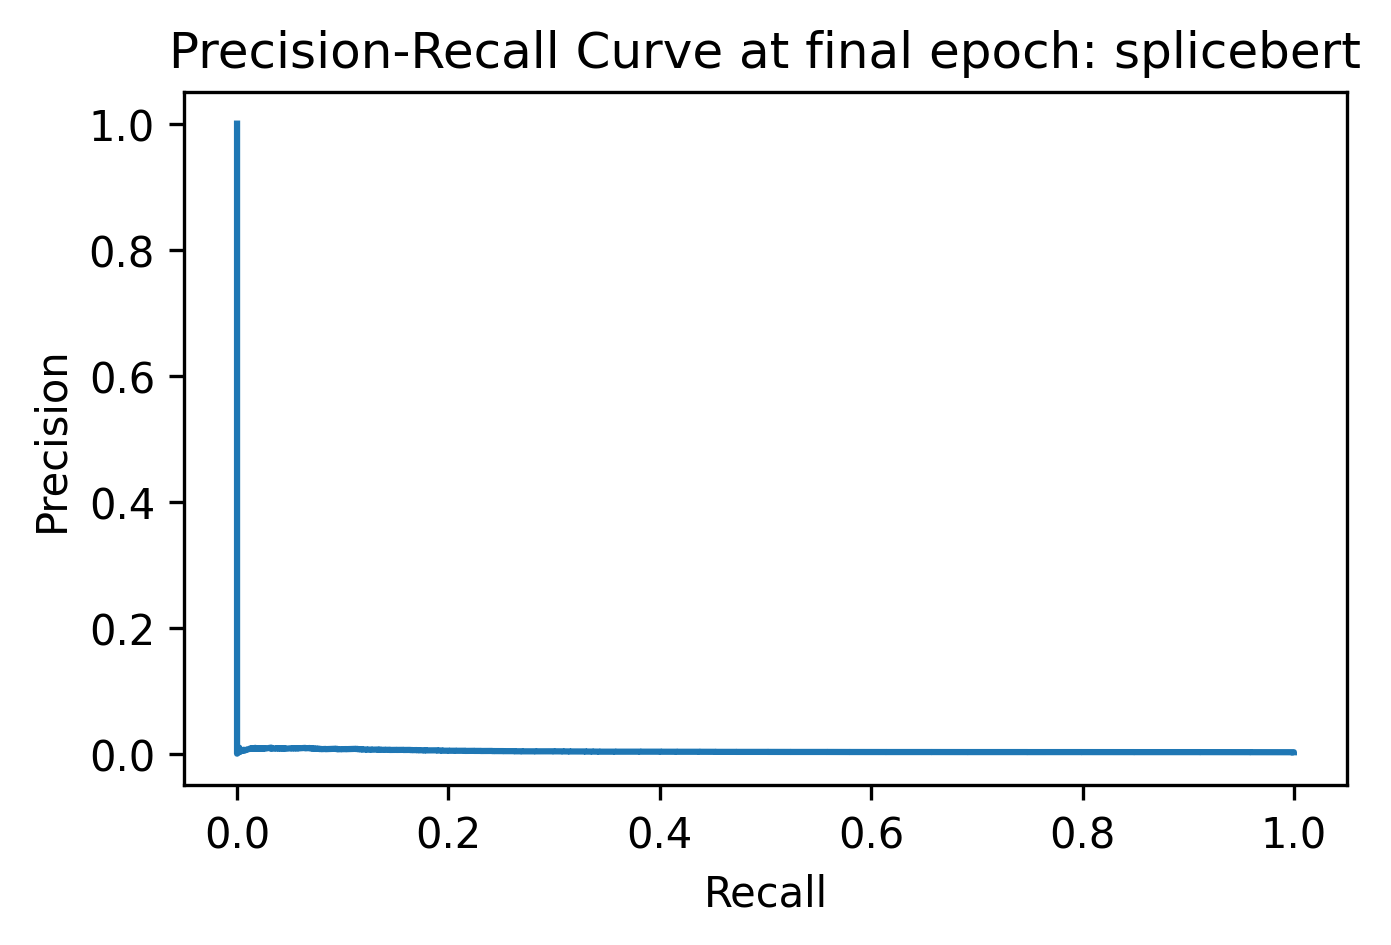

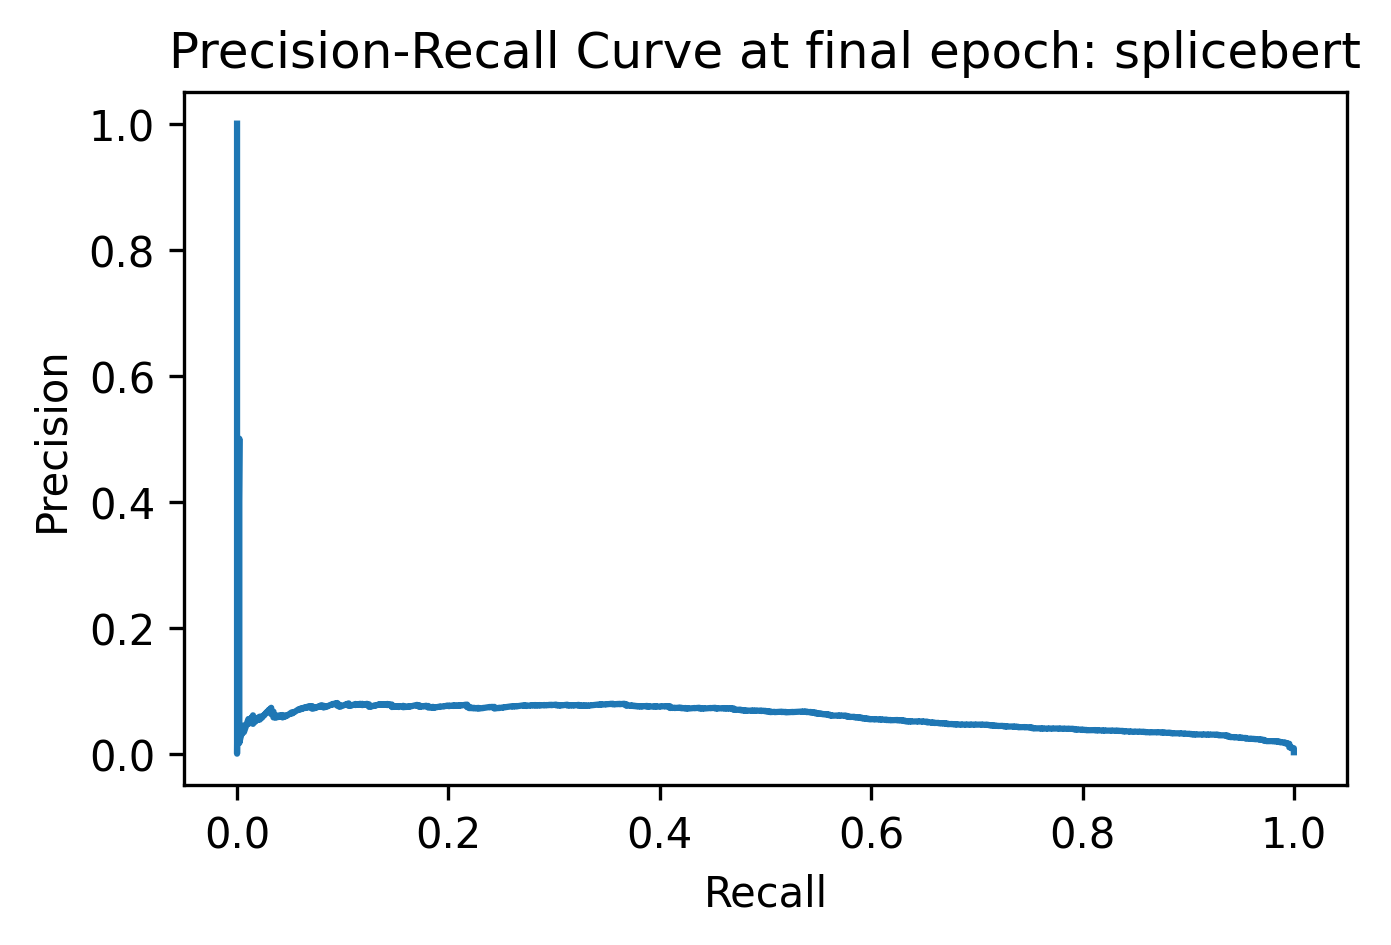

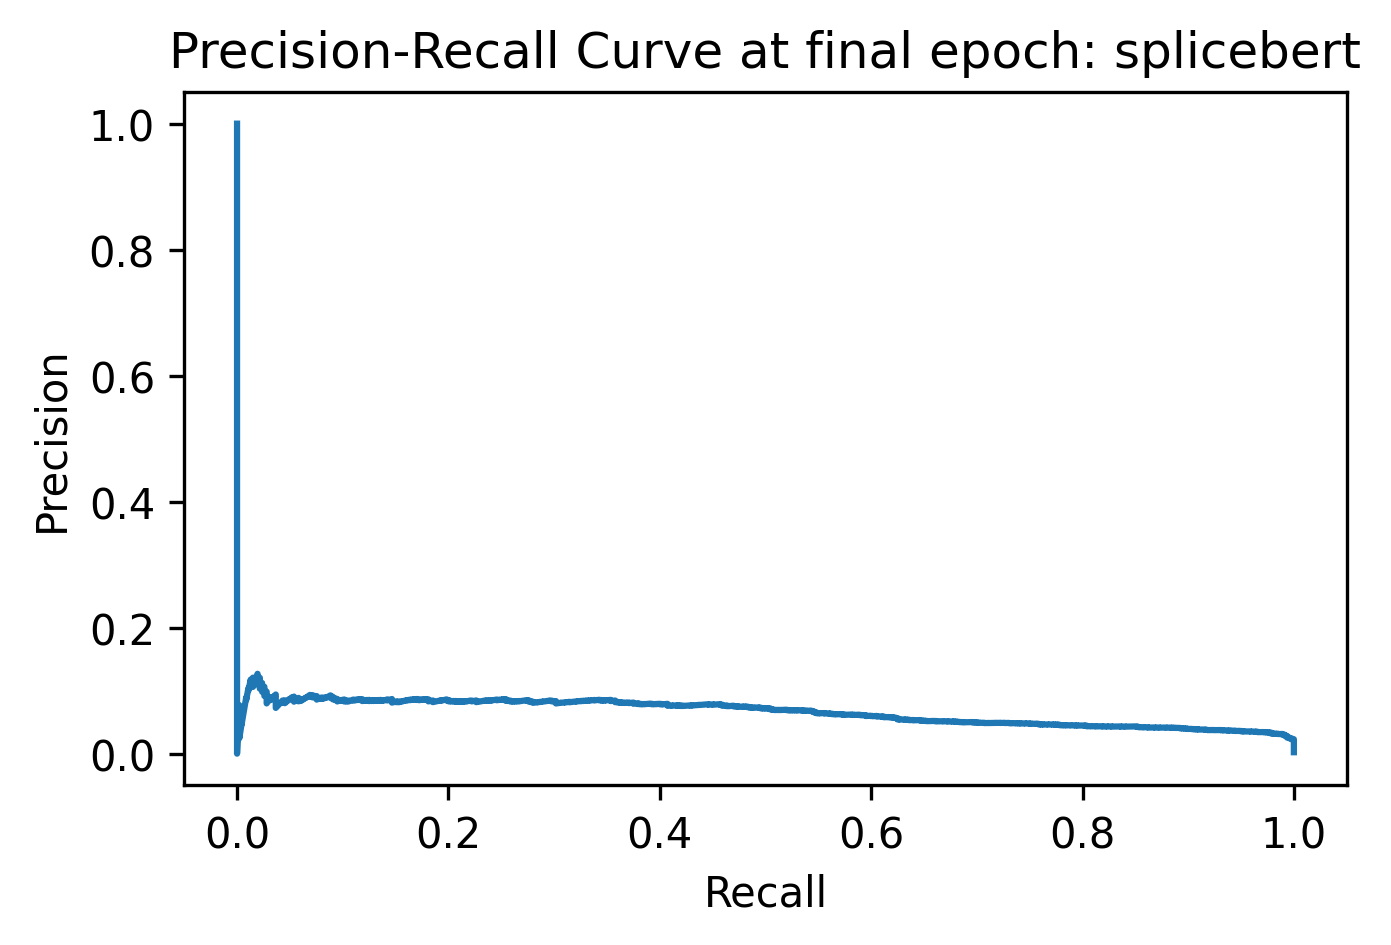

In [25]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    preprocess_logits_for_metrics = preprocess_logits_for_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()


In [27]:
trained_model = AutoModelForTokenClassification.from_pretrained(f"multimolecule-{MULTIMOLECULE_MODEL}-finetuned-secondary-structure/checkpoint-777") #make sure you are loading the right checkpoint
tokenizer = AutoTokenizer.from_pretrained(f"multimolecule-{MULTIMOLECULE_MODEL}-finetuned-secondary-structure/checkpoint-777")
data_collator = DataCollatorForTokenClassification(tokenizer)

In [28]:
#New metric w/out decision boundary optimization
F1_calc = load("f1")
def compute_metrics_test(eval_pred, file_name, decision_threshold):
    """
    Function to simultaneously evaluate accuracy, F1 and average precision (AP)

    The function does the evaluation per label for accuracy, and per token otherwise.

    average precision is the most interesting as it accounts for the fact that the
    ideal decision boundary may be something non trivial.

    F1 and accuracy are reported at the decision boundary which maximises the F1
    """
    logits, labels = eval_pred

    #Find predictions from logits
    predictions = softmax(logits, axis=2)[:,:,1] #probability of positive label

    #Reshape predictions and labels into long strings to compute metrics per token
    predictions_flat = predictions.reshape((-1,))
    labels_flat = labels.reshape((-1,))

    #Remove all the padded ones
    predictions_flat = predictions_flat[labels_flat!=-100]
    labels_flat_cleaned = labels_flat[labels_flat!=-100]

    #compute average precision
    AP = average_precision_score(labels_flat_cleaned, predictions_flat)

    #Plot precision curves
    precision, recall, thresholds = precision_recall_curve(labels_flat_cleaned, predictions_flat)
    fig, ax = plt.subplots(dpi = 300, figsize = (5,3))
    ax.set_ylabel("Precision")
    ax.set_xlabel("Recall")
    ax.set_title("Precision-Recall Curve at final epoch: splicebert", fontsize = 12)
    ax.plot(recall, precision)
    fig.savefig(file_name + ".png")

    np.savetxt("pr_curve.txt", np.vstack((precision,recall)).T)

    #Calculate accuracy
    categorical_predictions = np.where(predictions>decision_threshold, 1, 0)
    accuracy = compute_accuracy(labels, categorical_predictions)

    categorical_predictions_flat = categorical_predictions.reshape((-1,))
    categorical_predictions_flat = categorical_predictions_flat[labels_flat!=-100]

    F1 = F1_calc.compute(predictions=categorical_predictions_flat, references=labels_flat_cleaned)
    MCC = matthews_corrcoef(labels_flat_cleaned, categorical_predictions_flat)
    AUC = roc_auc_score(labels_flat_cleaned, categorical_predictions_flat)

    #Combine metrics
    dictionary = F1 | {"Seq. Acc" : accuracy} | {"AP" : AP} | {"MCC" : MCC} | {"AUC" : AUC}

    #Save the performance metrics to a text file
    with open(file_name + ".txt", 'w') as f:
      print(dictionary, file=f)

    #Return joint dictionary
    return dictionary

<ipython-input-29-70a66b0d7f49>:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  tester = Trainer(


Evaluation Metrics:
eval_loss: 0.009331279434263706
eval_model_preparation_time: 0.002
eval_f1: 0.051175395474884984
eval_Seq. Acc: 0.0
eval_AP: 0.0702669631260688
eval_MCC: 0.1551797358454554
eval_AUC: 0.9585846327811091
eval_runtime: 6.1184
eval_samples_per_second: 66.521
eval_steps_per_second: 4.249


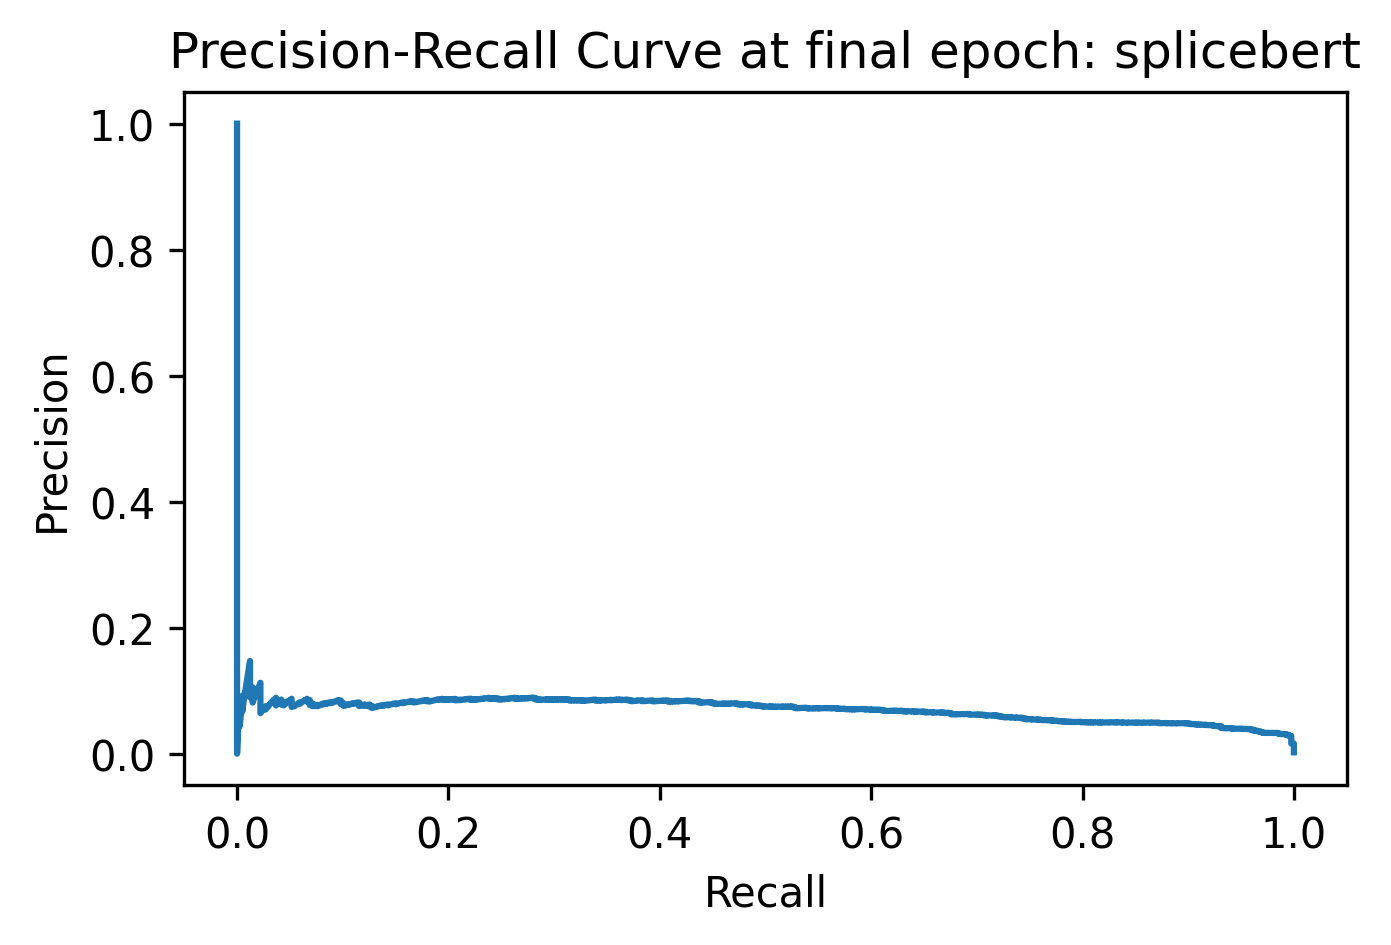

In [29]:
metric = lambda x: compute_metrics_test(x, "test_metrics", 0.001895)

testing_args = TrainingArguments(
    output_dir='/results',
    per_device_eval_batch_size=batch_size,
    do_eval=True,
    no_cuda=False,
)

tester = Trainer(
    model=trained_model,
    args=testing_args,
    eval_dataset=test_dataset,
    compute_metrics=metric,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

metrics = tester.evaluate()

print("Evaluation Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value}")